# Prevendo o nível de satisfação do cliente (Santander)

#### O Problema de Negócio

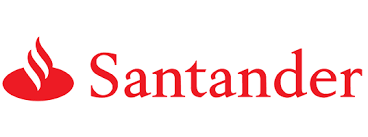

In [1]:
from IPython.display import Image
Image("Std.png")

Um desafio muito grande nos dias de hoje, é conseguir prever a satisfação do cliente. O Banco Santander solicitou ajuda ao [kaggle.com](http://kaggle.com) para identificar os clientes insatisfeitos no início do relacionamento, com isso permitirá a tomada de decisão proativa para melhorar o serviço antes que o cliente encerre o seu vínculo.

Dataset da competição: https://www.kaggle.com/c/santander-customer-satisfaction

O objetivo é prever se o cliente está satisfeito ou não com a sua experèncua bancária.

"TARGET" será a variável preditiva. O valor "0" se refere ao cliente satisfeito, e "1" para insatisfeito.



In [2]:
# Importando os pacotes.
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

In [3]:
# Importando os arquivos.
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

In [4]:
# Visualizando as primeiras linhas dos dados de treino.
display(df_train.head())

# Identificando os tipos de variáveis.
df_train.dtypes.unique()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


array([dtype('int64'), dtype('float64')], dtype=object)

### Análise Exploratória

In [5]:
# Analisando valores missing.
df_train.isnull().sum()

ID                         0
var3                       0
var15                      0
imp_ent_var16_ult1         0
imp_op_var39_comer_ult1    0
                          ..
saldo_medio_var44_hace3    0
saldo_medio_var44_ult1     0
saldo_medio_var44_ult3     0
var38                      0
TARGET                     0
Length: 371, dtype: int64

In [6]:
# Verificando a existência de colunas duplicadas.
df_train.columns.duplicated().sum()

0

In [7]:
# Shape dos dados de treino.
print(df_train.shape)

(76020, 371)


### Relação entre a idade e a satfisfação do cliente

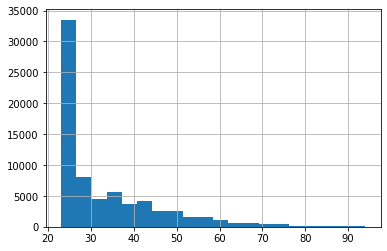

In [8]:
# Idade x satisfação.
df_train[(df_train.var15 > 22) & (df_train.var15 < 95) & (df_train.TARGET == 0)].var15.hist(bins = 20);

Nota-se que os clientes **entre 23 e 30 anos** são os mais satisfeitos com os serviços prestados. 

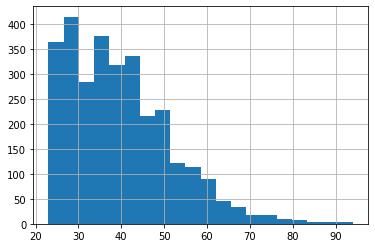

In [9]:
# Idade x Insatisfação.
df_train[(df_train.var15 > 22) & (df_train.var15 < 95) & (df_train.TARGET == 1)].var15.hist(bins = 20);

Neste caso, somente **a partir dos 70 anos**, a taxa de insatisfação é relativamente baixa.

In [ ]:
# Distribuição estatística dos dados.
df_train.describe()

TARGET
0    73012
1     3008
dtype: int64

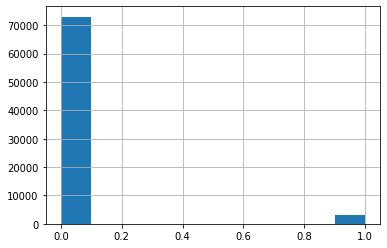

In [10]:
# Distribuição dos clientes satisfeitos e insatisfeitos nos dados de treino.
display(df_train.groupby("TARGET").size())

# Visualizando a distribuição.
df_train["TARGET"].hist()
plt.show()

Nota-se o desequilibrio da variável "Target", precisamos trabalhar para que o modelo aprenda de uma forma igual, para que o mesmo gera generalizável e não tendencioso.

### Removendo a coluna ID

Farei a remoção da coluna ID, pois a mesma não terá utilidade e caso seja usada no momento, pode influênciar negativamente no modelo.

In [11]:
# Deletando a coluna ID dos dados de treino.
df_train.drop(columns = ["ID"], inplace = True)

In [12]:
# Deletando a coluna ID dos dados de teste.
id_test = df_test["ID"]
df_test.drop(columns = ["ID"], inplace = True)

### Balanceando os dados

Nossa variável Target se encontra totalmente desequilibrada. Precisamos balanceá-la para que o modelo
aprenda de forma correta para que façamos as previsões que desejamos.

A superamostragem será utilizada com o SMOTE, pois ele cria novos exemplos de treinamento (artificial) com base nos 
exemplos de treinamento original. Se o SMOTE vê dois exemplos da mesma classe próximos um do outro, ele cria um terceiro
exemplo batendo no meio dos dois originais, isso o faz muito poderoso.

In [13]:
# Importando o pacote para balancear os dados de treino.
from imblearn.over_sampling import SMOTE

In [14]:
# Separando os dados.
dfValues = df_train
dfTarget = df_train.TARGET

In [15]:
# Removendo a variável target de dfValues.
dfValues.drop(columns="TARGET", inplace = True)

In [16]:
# Aplicando o balanceamento.
oversample = SMOTE()
X, Y = oversample.fit_resample(dfValues, dfTarget)

In [17]:
# Reshape dos dados balanceados.
print(X.shape)
print(Y.shape)

(146024, 369)
(146024,)


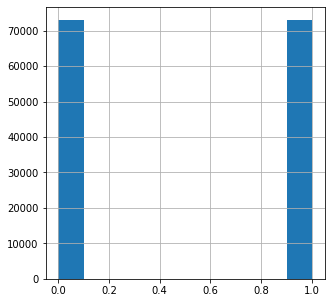

In [18]:
# Variável TARGET balanceada.
Y.hist(figsize = (5,5))
plt.show()

Após o balanceamento, o dataset está pronto para ser apresentado ao modelo de forma igual.

### Normalização dos dados de treino

Normalização se refere a ajustar a escala de cada observação (linha) de modo que ela tenha comprimento igual a 1 (chamado vetor de comprimento 1 em álgebra linear). Este método de pré-processamento é útil quando temos datasets esparsos (com muitos zeros) e atributos com escala muito variada.

In [60]:
# Carregando o pacote.
from sklearn.preprocessing import MinMaxScaler

In [61]:
# Normalizando os dados de treino.
scale = MinMaxScaler(feature_range = (0, 1))
trainNorm = scale.fit_transform(X)

In [62]:
# Convertendo o array resultante para um dataframe.
trainNorm = pd.DataFrame(trainNorm)

In [63]:
# Comparando os dados de treino.
print("\nNão normalizados: \n\n:", X.values[0:3,:])
print("\nNormalizados: \n\n", trainNorm.values[0:3,:])


Não normalizados: 

: [[2.000000e+00 2.300000e+01 0.000000e+00 ... 0.000000e+00 0.000000e+00
  3.920517e+04]
 [2.000000e+00 3.400000e+01 0.000000e+00 ... 0.000000e+00 0.000000e+00
  4.927803e+04]
 [2.000000e+00 2.300000e+01 0.000000e+00 ... 0.000000e+00 0.000000e+00
  6.733377e+04]]

Normalizados: 

 [[0.99976406 0.18       0.         ... 0.         0.         0.00154526]
 [0.99976406 0.29       0.         ... 0.         0.         0.0020025 ]
 [0.99976406 0.18       0.         ... 0.         0.         0.00282212]]


### Normalização dos dados de teste

In [64]:
# Normalizando os dados de teste.
testNorm = scale.fit_transform(df_test)

In [65]:
# Convertendo o array resultante para um dataframe.
testNorm = pd.DataFrame(testNorm)

In [66]:
# Comparando os dados de teste.
print("\nNão normalizados: \n\n:", df_test.values[0:3,:])
print("\nNormalizados: \n\n", testNorm.values[0:3,:])


Não normalizados: 

: [[2.000000e+00 3.200000e+01 0.000000e+00 ... 0.000000e+00 0.000000e+00
  4.053210e+04]
 [2.000000e+00 3.500000e+01 0.000000e+00 ... 0.000000e+00 0.000000e+00
  4.548672e+04]
 [2.000000e+00 2.300000e+01 0.000000e+00 ... 0.000000e+00 0.000000e+00
  4.699395e+04]]

Normalizados: 

 [[0.99976406 0.27       0.         ... 0.         0.         0.0013612 ]
 [0.99976406 0.3        0.         ... 0.         0.         0.00153268]
 [0.99976406 0.18       0.         ... 0.         0.         0.00158484]]


### PCA - Redução de Dimensionalidade

A aplicação do PCA é um metodo para extração das variáveis importantes (na forma de componentes) a partir de um grande conjunto de variáveis. Permite extrair um número pequeno de conjuntos dimensionais a partir de um dataset altamente dimensional. Com menos variáveis, a visualização também se torna muito mais significativa. Usarei o PCA para selecionar 50 componentes (grupo de variáveis) principais.

Cada componente resultante é uma combinação linear de n atributos. Ou seja, cada componente principal é uma combinação de atributos presentes no dataset.

In [67]:
# Carregando o pacote.
from sklearn.decomposition import PCA

In [68]:
# Separando os dados.
x_train = trainNorm
y_train = Y 

In [69]:
# Selecionando os componentes.
pca = PCA(n_components = 50)

In [70]:
# Reduzindo os dados de treino.
train_pca = pca.fit_transform(x_train)

In [71]:
# Variancia de cada componente.
print("Variancia de cada componente:", pca.explained_variance_ratio_)

Variancia de cada componente: [3.51102962e-01 1.62509322e-01 1.26156407e-01 6.64054137e-02
 5.57029738e-02 4.44730574e-02 3.20817985e-02 2.36738522e-02
 1.84975569e-02 1.20850424e-02 9.82841352e-03 9.73334294e-03
 7.70202670e-03 7.28084653e-03 7.15562414e-03 5.60520524e-03
 5.30178274e-03 5.00010882e-03 4.29780445e-03 3.71783318e-03
 3.03132321e-03 3.00666286e-03 2.76618404e-03 2.64853657e-03
 2.56862150e-03 1.99358157e-03 1.67011902e-03 1.48768118e-03
 1.32964802e-03 1.22266035e-03 1.18706096e-03 1.10480274e-03
 1.07169261e-03 8.97061483e-04 8.70525143e-04 7.75714512e-04
 6.91715438e-04 6.12666177e-04 5.77536316e-04 5.65541332e-04
 5.53381242e-04 5.35315713e-04 5.23758321e-04 5.00013393e-04
 4.86243766e-04 4.32028661e-04 3.90802490e-04 3.64111085e-04
 3.62598691e-04 3.46010973e-04]


In [72]:
# Verificando a variabilidade total dos componentes.
print("\n Total da variância:", round(sum(list(pca.explained_variance_ratio_))*100, 2))


 Total da variância: 99.29


In [73]:
# Dados de treino após a redução.
train_pca.shape

(146024, 50)

In [74]:
# Aplicando a redução nos dados de teste.
test_pca = pca.fit_transform(df_test)

In [75]:
# Dados de teste após a redução.
test_pca.shape

(75818, 50)

# XGBoost - (Modelo v1)

 A principal vantagem do XGBoost sobre o GBM é sua capacidade de gerenciar dados esparsos. O XGBoost automaticamente aceita dados esparsos como input sem armazenar zeros na memória. Basicamente o XGBoost utiliza os mesmos parâmetros do GBM e permite tratamento avançado de dados missing.

In [76]:
# Importando os pacotes.
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

In [77]:
# Criando o dataset de treino e de teste
X_treino, X_teste, y_treino, y_teste = train_test_split(train_pca, Y, test_size = 0.30, random_state = 0)

In [130]:
# Instânciando o modelo.
modelo1 = XGBClassifier()

In [131]:
# Treinando o modelo v1.
modelo1.fit(X_treino, y_treino)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [132]:
# Fazendo as previsões e gerando a confusion matrix.
y_pred = modelo1.predict(X_teste)
matrix = confusion_matrix(y_teste, y_pred)

In [133]:
# Visualizando a matrix
print(matrix)

[[19169  2607]
 [ 2082 19950]]


In [134]:
# Fazendo a avaliação com os dados de treino.
accuracy = accuracy_score(y_teste, y_pred)
print("Acurácia: %.2f%%" % (accuracy * 100.0))

Acurácia: 89.30%


# Suport Vector Machines - (Modelo v2)

O SVM padrão toma como entrada um conjunto de dados e prediz, para cada entrada dada, qual de duas possíveis classes a entrada faz parte.

In [83]:
# Carregando os pocotes.
from sklearn.model_selection import KFold
from sklearn.svm import SVC

In [84]:
# Número de folds.
folds = 10

In [85]:
# Separando os dados em folds.
kfold = KFold(folds, True, random_state = 5)

In [86]:
# Instânciando o modelo.
modelo2 = SVC()

In [87]:
# Treinando o modelo v2.
modelo2.fit(X_treino, y_treino)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [88]:
# Fazendo as previsões e gerando a confusion matrix.
y_pred2 = modelo2.predict(X_teste)
matrix2 = confusion_matrix(y_teste, y_pred2)

In [89]:
# Visualizando a matrix
print(matrix2)

[[18880  2896]
 [ 3979 18053]]


In [90]:
# Fazendo a avaliação com os dados de treino.
accuracy2 = accuracy_score(y_teste, y_pred2)
print("Acurácia: %.2f%%" % (accuracy2 * 100.0))

Acurácia: 84.31%


# CART -  (Modelo v3)

O algoritmo constrói uma árvore binária a partir do dataset de treino. Cada atributo e cada valor de cada atributo são avaliados com o objetivo de reduzir a função de custo (Cost Function).

In [91]:
# Importando o pacote.
from sklearn.tree import DecisionTreeClassifier

In [98]:
# Definido e separando os dados em folds.
num_folds = 10
kfold = KFold(num_folds, True, random_state = 42)

In [99]:
# Instânciando o modelo.
modelo3 = DecisionTreeClassifier()

In [100]:
# Treinando o modelo v3.
modelo3.fit(X_treino, y_treino)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [101]:
# Fazendo as previsões e gerando a confusion matrix.
y_pred3 = modelo3.predict(X_teste)
matrix3 = confusion_matrix(y_teste, y_pred3)

In [102]:
# Visualizando a matrix
print(matrix3)

[[19105  2671]
 [ 2319 19713]]


In [103]:
# Fazendo a avaliação com os dados de treino.
accuracy3 = accuracy_score(y_teste, y_pred3)
print("Acurácia: %.2f%%" % (accuracy3 * 100.0))

Acurácia: 88.61%


### Visualizando os resultados dos modelos

In [135]:
print("Acurácia XGBoost: %.1f%%" % (accuracy * 100.0))
print("Acurácia SVM: %.1f%%" % (accuracy2 * 100.0))
print("Acurácia CART: %.1f%%" % (accuracy3 * 100.0))

Acurácia XGBoost: 89.3%
Acurácia SVM: 84.3%
Acurácia CART: 88.6%


O modelo **XGBoost** será o escolhido para fazer as previsões.

In [136]:
# Previsão com os dados de teste.
submiss = modelo1.predict(test_pca)

In [137]:
# Gerando os dados de submissão e utilizando a coluna ID dos dados de teste.
submission = pd.DataFrame({
    "ID": id_test,
    "Target": submiss
})

In [138]:
# Visualizando as previsões.
submission.head()

,ID,Target
0,2,1
1,5,1
2,6,1
3,7,0
4,9,1


In [139]:
# Salvando os resultados em um CSV.
submission.to_csv("Santander_predict.csv", index = False)

# Conclusão

O dataset por ser oculto, contém inumeras colunas e não conter um dicionário de dados, dificutou bastante o entendimento das varíaveis e dos dados em si. Muitas informações foram obtidas por outros membros da competição, no que colaborou para o entendimento.

Foram testados **3 modelos diferentes**, os dados foram tratados, normalizados e equilibrados, para que o modelo aplicado pudesse dar o melhor resultado possível.

A melhor acurácia foi com o modelo **XGBOOST**, na qual obteve uma média de **89%** de acurácia.